In [28]:
import pandas as pd
import numpy as np

import os
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

%load_ext tensorboard

import matplotlib.pyplot as plt
from skimage import color, exposure

from sklearn.metrics import accuracy_score


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
cd "/content/drive/My Drive/Colab Notebooks/dw_matrix_three/dw_matrix_road_sign/"

/content/drive/My Drive/Colab Notebooks/dw_matrix_three/dw_matrix_road_sign


In [3]:
ls


data/       Day2.ipynb  Day4.ipynb  logs/
Day1.ipynb  Day3.ipynb  LICENSE     README.md


In [0]:
train = pd.read_pickle('data/train.p')
test = pd.read_pickle('data/test.p')

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [5]:
len(np.unique(y_train))

43

In [0]:
if y_train.ndim == 1:
  y_train = to_categorical(y_train)

if y_test.ndim == 1:
  y_test = to_categorical(y_test)


In [0]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [8]:
model = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
  Flatten(),
  Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 43)                2476843   
Total params: 2,478,635
Trainable params: 2,478,635
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, y_train)

1088/1088 [==============================] - 5s 5ms/step - loss: 7.0103 - accuracy: 0.7768


In [0]:
def get_cnn_v1(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Flatten(),
    Dense(num_classes, activation='softmax')
  ])

def train_model(model, X_train, y_train, params_fit={}):
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


  model.fit(
      X_train, 
      y_train,
      batch_size=params_fit.get('batch_size', 128),
      epochs=params_fit.get('epochs', 5),
      verbose=params_fit.get('verbose', 1),
      validation_data=params_fit.get('validation_data', (X_train, y_train)),
      callbacks=[tensorboard_callback]
  )

  return model


In [19]:
model = get_cnn_v1(input_shape, num_classes)
model_trained = train_model(model, X_train, y_train)

Epoch 1/5
272/272 [==============================] - 5s 17ms/step - loss: 48.6719 - accuracy: 0.7469 - val_loss: 0.2552 - val_accuracy: 0.9452
Epoch 2/5
272/272 [==============================] - 5s 17ms/step - loss: 0.2230 - accuracy: 0.9525 - val_loss: 0.1137 - val_accuracy: 0.9726
Epoch 3/5
272/272 [==============================] - 4s 17ms/step - loss: 0.1576 - accuracy: 0.9669 - val_loss: 0.1017 - val_accuracy: 0.9758
Epoch 4/5
272/272 [==============================] - 5s 17ms/step - loss: 0.1623 - accuracy: 0.9642 - val_loss: 0.0771 - val_accuracy: 0.9816
Epoch 5/5
272/272 [==============================] - 5s 17ms/step - loss: 0.1121 - accuracy: 0.9753 - val_loss: 0.1223 - val_accuracy: 0.9788


In [24]:
y_pred_prob = model_trained.predict(X_test)
y_pred_prob[400]

array([8.6581519e-14, 9.9906212e-01, 2.6812857e-10, 1.4763322e-15,
       7.8673789e-04, 1.4689581e-05, 1.0469881e-15, 6.7798670e-19,
       4.8587311e-13, 2.2748061e-09, 8.1893806e-12, 1.9554475e-17,
       2.1228086e-13, 4.9644745e-13, 1.4194067e-15, 1.3643347e-04,
       9.3474863e-15, 1.0813354e-24, 1.3302422e-10, 1.6262948e-32,
       4.4416921e-15, 1.0185456e-22, 6.6090805e-27, 2.0086144e-22,
       3.1276803e-18, 5.5354642e-20, 2.0150262e-11, 1.6663425e-31,
       6.8285124e-18, 4.7844180e-16, 3.6574550e-24, 5.7883831e-20,
       4.4533845e-14, 2.7623985e-35, 5.1212693e-33, 1.5674430e-19,
       9.3443278e-27, 2.2334165e-36, 1.5694789e-32, 1.9700145e-35,
       1.9634535e-24, 8.2035686e-21, 4.6738219e-22], dtype=float32)

<BarContainer object of 43 artists>

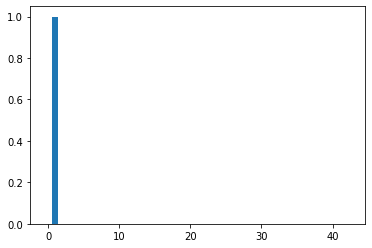

In [27]:
plt.bar(range(43), y_pred_prob[400])

In [26]:
labels_dict[np.argmax(y_pred_prob[400])]


'Speed limit (30km/h)'

ERROR! Session/line number was not unique in database. History logging moved to new session 59


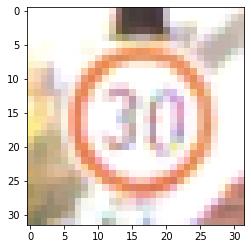

In [21]:
plt.imshow(X_test[400])

In [0]:
df = pd.read_csv('data/signnames.csv')
labels_dict = df.to_dict()['b']

In [0]:
def predict(model_trained, X_test, y_test, scoring=accuracy_score):
  y_test_norm = np.argmax(y_test, axis=1)

  y_pred_prob = model_trained.predict(X_test)

  y_pred = np.argmax(y_pred_prob, axis=1)

  return scoring(y_test_norm, y_pred)

In [31]:
predict(model_trained, X_test, y_test)

0.8061224489795918

In [0]:
def train_and_predict(model):
  model_trained = train_model(model, X_train, y_train)
  return predict(model_trained, X_test, y_test)

In [37]:
def get_cnn_v2(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ),
    MaxPool2D(),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
  ])

train_and_predict(get_cnn_v2(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 4s 14ms/step - loss: 5.5251 - accuracy: 0.2147 - val_loss: 2.3403 - val_accuracy: 0.3781
Epoch 2/5
272/272 [==============================] - 4s 14ms/step - loss: 1.7100 - accuracy: 0.5107 - val_loss: 0.8285 - val_accuracy: 0.7783
Epoch 3/5
272/272 [==============================] - 4s 13ms/step - loss: 0.9117 - accuracy: 0.7246 - val_loss: 0.3204 - val_accuracy: 0.9153
Epoch 4/5
272/272 [==============================] - 4s 14ms/step - loss: 0.5300 - accuracy: 0.8401 - val_loss: 0.1906 - val_accuracy: 0.9584
Epoch 5/5
272/272 [==============================] - 4s 13ms/step - loss: 0.3656 - accuracy: 0.8920 - val_loss: 0.0951 - val_accuracy: 0.9801


0.8952380952380953

In [38]:
def get_cnn_v3(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ),
    MaxPool2D(),
    Dropout(0.3),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
  ])

train_and_predict(get_cnn_v3(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 5s 20ms/step - loss: 1.8502 - accuracy: 0.5654 - val_loss: 0.3365 - val_accuracy: 0.9171
Epoch 2/5
272/272 [==============================] - 5s 19ms/step - loss: 0.4890 - accuracy: 0.8486 - val_loss: 0.1356 - val_accuracy: 0.9687
Epoch 3/5
272/272 [==============================] - 5s 18ms/step - loss: 0.3026 - accuracy: 0.9069 - val_loss: 0.0935 - val_accuracy: 0.9792
Epoch 4/5
272/272 [==============================] - 5s 18ms/step - loss: 0.2381 - accuracy: 0.9259 - val_loss: 0.0606 - val_accuracy: 0.9835
Epoch 5/5
272/272 [==============================] - 5s 19ms/step - loss: 0.1882 - accuracy: 0.9418 - val_loss: 0.0428 - val_accuracy: 0.9889


0.9496598639455782

In [44]:
def get_cnn_v4(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ),
    MaxPool2D(),
    Dropout(0.3),


    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
  ])

train_and_predict(get_cnn_v4(input_shape, num_classes))
#get_cnn_v4(input_shape, num_classes).summary()

Epoch 1/5
272/272 [==============================] - 6s 23ms/step - loss: 2.6251 - accuracy: 0.2998 - val_loss: 0.9135 - val_accuracy: 0.7251
Epoch 2/5
272/272 [==============================] - 6s 22ms/step - loss: 0.7775 - accuracy: 0.7588 - val_loss: 0.1950 - val_accuracy: 0.9511
Epoch 3/5
272/272 [==============================] - 6s 21ms/step - loss: 0.3634 - accuracy: 0.8897 - val_loss: 0.0723 - val_accuracy: 0.9816
Epoch 4/5
272/272 [==============================] - 6s 21ms/step - loss: 0.2251 - accuracy: 0.9330 - val_loss: 0.0442 - val_accuracy: 0.9890
Epoch 5/5
272/272 [==============================] - 6s 21ms/step - loss: 0.1726 - accuracy: 0.9495 - val_loss: 0.0311 - val_accuracy: 0.9909


0.9700680272108844

In [45]:
def get_cnn_v5(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ),
    MaxPool2D(),
    Dropout(0.3),


    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(1024, activation='relu'),
    Dropout(0.3),


    Dense(num_classes, activation='softmax')
  ])

train_and_predict(get_cnn_v5(input_shape, num_classes))
#get_cnn_v4(input_shape, num_classes).summary()

Epoch 1/5
272/272 [==============================] - 6s 24ms/step - loss: 2.7107 - accuracy: 0.2492 - val_loss: 1.5579 - val_accuracy: 0.4939
Epoch 2/5
272/272 [==============================] - 6s 23ms/step - loss: 1.3831 - accuracy: 0.5436 - val_loss: 0.5921 - val_accuracy: 0.8142
Epoch 3/5
272/272 [==============================] - 6s 23ms/step - loss: 0.6761 - accuracy: 0.7816 - val_loss: 0.1727 - val_accuracy: 0.9508
Epoch 4/5
272/272 [==============================] - 6s 24ms/step - loss: 0.3685 - accuracy: 0.8874 - val_loss: 0.0967 - val_accuracy: 0.9730
Epoch 5/5
272/272 [==============================] - 6s 23ms/step - loss: 0.2409 - accuracy: 0.9282 - val_loss: 0.0783 - val_accuracy: 0.9768


0.9560090702947845

In [46]:
X_train[0].shape

(32, 32, 3)

In [0]:
X_train_gray = color.rgb2gray(X_train).reshape(-1, 32, 32, 1)
X_test_gray = color.rgb2gray(X_test).reshape(-1, 32, 32, 1)

In [54]:
model = get_cnn_v5((32, 32, 1), num_classes)
model_trained = train_model(model, X_train_gray, y_train)
predict(model_trained, X_test_gray, y_test)

Epoch 1/5
272/272 [==============================] - 6s 24ms/step - loss: 2.4694 - accuracy: 0.3045 - val_loss: 0.6180 - val_accuracy: 0.7997
Epoch 2/5
272/272 [==============================] - 6s 23ms/step - loss: 0.5452 - accuracy: 0.8217 - val_loss: 0.1650 - val_accuracy: 0.9468
Epoch 3/5
272/272 [==============================] - 6s 22ms/step - loss: 0.2513 - accuracy: 0.9201 - val_loss: 0.0565 - val_accuracy: 0.9832
Epoch 4/5
272/272 [==============================] - 6s 23ms/step - loss: 0.1594 - accuracy: 0.9492 - val_loss: 0.0558 - val_accuracy: 0.9822
Epoch 5/5
272/272 [==============================] - 6s 23ms/step - loss: 0.1223 - accuracy: 0.9607 - val_loss: 0.0354 - val_accuracy: 0.9890


0.9659863945578231

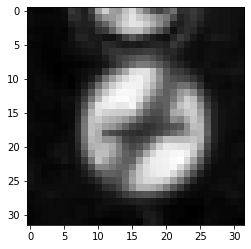

In [50]:
plt.imshow(color.rgb2gray(X_train[0]), cmap=plt.get_cmap('gray'))

In [0]:
def preproc_img(img):
  hsv = color.rgb2hsv(img)
  hsv[:,:,2] = exposure.equalize_adapthist(hsv[:,:,2])
  img = color.hsv2rgb(hsv)

  return img

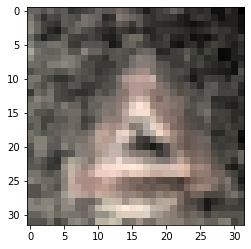

In [56]:
plt.imshow(preproc_img(X_train[400]))

In [0]:
X_train_prp = X_train.copy().astype(np.float32)
X_test_prp = X_test.copy().astype(np.float32)

for i in tqdm(range(X_train.shape[0])):
  X_train_prp[i] = preproc_img(X_train[i])
  

What next? Read:

https://github.com/joshwadd/Deep-traffic-sign-classification
